In [795]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [796]:
borrar = ["Opportunity_Name", "ID", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "Actual_Delivery_Date", "Last_Activity", 
          "ASP_converted_Currency", "Prod_Category_A", "Product_Name", "Delivery_Year", "Month", 
          "TRF", "Product_Family", "Account_Name"]

useless = ["Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", "Price", "ASP_Currency", 
           "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type"] # "Product_Category_B", "Region"]

dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date"]

target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [797]:
def preprocess(data):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = data.Opportunity_Owner == data.Last_Modified_By
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort = False)["Account_Name"].transform("count")
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    #data.loc[data.Concrete_Offer <= 0, 'Concrete_Offer'] = 0
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    #data.loc[data.Offer_Duration <= 0, 'Offer_Duration'] = -1
    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    #data.loc[(data.Past_Quote <= 100) & (data.Past_Quote > 0), 'Past_Quote'] = 1
    #data.loc[(data.Past_Quote >= -100) & (data.Past_Quote < 0), 'Past_Quote'] = -1
    #data.loc[data.Past_Quote < -100, 'Past_Quote'] = -2
    #data.loc[data.Past_Quote > 100, 'Past_Quote'] = 2
    #data['Past_Quote'].astype('category')
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(borrar + useless + dates, axis = 1)
    
    #data.drop(data[(data.Contacts > 1) & (data.ASP.isna())].index, inplace = True)
    #data = data.drop_duplicates([x for x in data.columns if x != 'ID'])
    
    return (data)

In [798]:
import catboost as ctb

In [799]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [800]:
rest = [x for x in data.columns if x != 'ID']
len(data[data.duplicated(rest)])/float(len(data)) * 100

2.643535729037588

In [801]:
prep = preprocess(data)

In [802]:
prep = prep[(prep.Stage == "Closed Won") | (prep.Stage == "Closed Lost")]
prep.Stage = prep.Stage.replace({"Closed Won": 1, "Closed Lost": 0})

In [803]:
len(prep[prep.duplicated()])

481

In [804]:
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size=0.3, random_state=0)

In [805]:
cat_vars = [x for x in x_train.drop(target, axis=1).select_dtypes('category').columns if x != 'Stage']

In [806]:
cat_vars

['Region',
 'Territory',
 'Bureaucratic_Code',
 'Source',
 'Billing_Country',
 'Account_Owner',
 'Opportunity_Owner',
 'Currency',
 'Last_Modified_By',
 'Delivery_Quarter']

In [807]:
cat_indexes = [x_train.drop(target, axis=1).columns.get_loc(x) for x in cat_vars]

In [808]:
cat_indexes

[0, 1, 6, 7, 8, 9, 10, 11, 12, 15]

In [809]:
model = ctb.CatBoostClassifier(num_boost_round=5000,
                               learning_rate=0.015,
                               l2_leaf_reg=3.5,
                               depth=8, 
                               max_bin=400,
                               num_leaves=31,
                               rsm=0.98,
                               eval_metric='Logloss',
                               use_best_model=True)

In [810]:
model.fit(x_train.drop(target, axis=1), y_train, eval_set=(x_test.drop(target, axis=1), y_test), cat_features=cat_indexes, early_stopping_rounds=800)

0:	learn: 0.6679531	test: 0.6682930	best: 0.6682930 (0)	total: 23.8ms	remaining: 1m 59s
1:	learn: 0.6465240	test: 0.6471160	best: 0.6471160 (1)	total: 30.1ms	remaining: 1m 15s
2:	learn: 0.6235090	test: 0.6242381	best: 0.6242381 (2)	total: 39.2ms	remaining: 1m 5s
3:	learn: 0.6031314	test: 0.6040542	best: 0.6040542 (3)	total: 46.7ms	remaining: 58.3s
4:	learn: 0.5820636	test: 0.5832737	best: 0.5832737 (4)	total: 64.4ms	remaining: 1m 4s
5:	learn: 0.5622983	test: 0.5637942	best: 0.5637942 (5)	total: 84.3ms	remaining: 1m 10s
6:	learn: 0.5442029	test: 0.5459132	best: 0.5459132 (6)	total: 91ms	remaining: 1m 4s
7:	learn: 0.5280871	test: 0.5299992	best: 0.5299992 (7)	total: 96.6ms	remaining: 1m
8:	learn: 0.5089577	test: 0.5111354	best: 0.5111354 (8)	total: 114ms	remaining: 1m 3s
9:	learn: 0.4926150	test: 0.4947746	best: 0.4947746 (9)	total: 129ms	remaining: 1m 4s
10:	learn: 0.4787206	test: 0.4810805	best: 0.4810805 (10)	total: 133ms	remaining: 1m
11:	learn: 0.4637352	test: 0.4662901	best: 0.4662

99:	learn: 0.1192694	test: 0.1304064	best: 0.1304064 (99)	total: 1.68s	remaining: 1m 22s
100:	learn: 0.1184521	test: 0.1297233	best: 0.1297233 (100)	total: 1.7s	remaining: 1m 22s
101:	learn: 0.1178756	test: 0.1291871	best: 0.1291871 (101)	total: 1.72s	remaining: 1m 22s
102:	learn: 0.1173354	test: 0.1286600	best: 0.1286600 (102)	total: 1.74s	remaining: 1m 22s
103:	learn: 0.1166955	test: 0.1280964	best: 0.1280964 (103)	total: 1.75s	remaining: 1m 22s
104:	learn: 0.1162788	test: 0.1277391	best: 0.1277391 (104)	total: 1.77s	remaining: 1m 22s
105:	learn: 0.1156123	test: 0.1270985	best: 0.1270985 (105)	total: 1.79s	remaining: 1m 22s
106:	learn: 0.1152900	test: 0.1268203	best: 0.1268203 (106)	total: 1.81s	remaining: 1m 22s
107:	learn: 0.1147550	test: 0.1263684	best: 0.1263684 (107)	total: 1.83s	remaining: 1m 22s
108:	learn: 0.1143381	test: 0.1259985	best: 0.1259985 (108)	total: 1.84s	remaining: 1m 22s
109:	learn: 0.1140418	test: 0.1257546	best: 0.1257546 (109)	total: 1.86s	remaining: 1m 22s
11

195:	learn: 0.0891919	test: 0.1042384	best: 0.1042384 (195)	total: 3.56s	remaining: 1m 27s
196:	learn: 0.0891053	test: 0.1042095	best: 0.1042095 (196)	total: 3.58s	remaining: 1m 27s
197:	learn: 0.0888645	test: 0.1039491	best: 0.1039491 (197)	total: 3.6s	remaining: 1m 27s
198:	learn: 0.0887314	test: 0.1038400	best: 0.1038400 (198)	total: 3.61s	remaining: 1m 27s
199:	learn: 0.0887102	test: 0.1038285	best: 0.1038285 (199)	total: 3.62s	remaining: 1m 26s
200:	learn: 0.0885582	test: 0.1037732	best: 0.1037732 (200)	total: 3.64s	remaining: 1m 26s
201:	learn: 0.0884038	test: 0.1036569	best: 0.1036569 (201)	total: 3.66s	remaining: 1m 26s
202:	learn: 0.0883504	test: 0.1036053	best: 0.1036053 (202)	total: 3.67s	remaining: 1m 26s
203:	learn: 0.0883488	test: 0.1036067	best: 0.1036053 (202)	total: 3.68s	remaining: 1m 26s
204:	learn: 0.0882234	test: 0.1034825	best: 0.1034825 (204)	total: 3.7s	remaining: 1m 26s
205:	learn: 0.0882190	test: 0.1034787	best: 0.1034787 (205)	total: 3.7s	remaining: 1m 26s
20

295:	learn: 0.0791191	test: 0.0965457	best: 0.0965457 (295)	total: 5.24s	remaining: 1m 23s
296:	learn: 0.0789950	test: 0.0964814	best: 0.0964814 (296)	total: 5.26s	remaining: 1m 23s
297:	learn: 0.0789074	test: 0.0964233	best: 0.0964233 (297)	total: 5.28s	remaining: 1m 23s
298:	learn: 0.0787615	test: 0.0963410	best: 0.0963410 (298)	total: 5.3s	remaining: 1m 23s
299:	learn: 0.0787283	test: 0.0963270	best: 0.0963270 (299)	total: 5.32s	remaining: 1m 23s
300:	learn: 0.0787204	test: 0.0963255	best: 0.0963255 (300)	total: 5.33s	remaining: 1m 23s
301:	learn: 0.0786506	test: 0.0962511	best: 0.0962511 (301)	total: 5.34s	remaining: 1m 23s
302:	learn: 0.0786048	test: 0.0962326	best: 0.0962326 (302)	total: 5.37s	remaining: 1m 23s
303:	learn: 0.0783659	test: 0.0960118	best: 0.0960118 (303)	total: 5.39s	remaining: 1m 23s
304:	learn: 0.0783108	test: 0.0959767	best: 0.0959767 (304)	total: 5.41s	remaining: 1m 23s
305:	learn: 0.0781476	test: 0.0958727	best: 0.0958727 (305)	total: 5.43s	remaining: 1m 23s


394:	learn: 0.0717832	test: 0.0909426	best: 0.0909426 (394)	total: 6.9s	remaining: 1m 20s
395:	learn: 0.0717542	test: 0.0909243	best: 0.0909243 (395)	total: 6.92s	remaining: 1m 20s
396:	learn: 0.0717539	test: 0.0909239	best: 0.0909239 (396)	total: 6.93s	remaining: 1m 20s
397:	learn: 0.0717417	test: 0.0909197	best: 0.0909197 (397)	total: 6.94s	remaining: 1m 20s
398:	learn: 0.0717412	test: 0.0909193	best: 0.0909193 (398)	total: 6.94s	remaining: 1m 20s
399:	learn: 0.0717392	test: 0.0909192	best: 0.0909192 (399)	total: 6.95s	remaining: 1m 19s
400:	learn: 0.0716641	test: 0.0908724	best: 0.0908724 (400)	total: 6.97s	remaining: 1m 19s
401:	learn: 0.0714812	test: 0.0907704	best: 0.0907704 (401)	total: 6.99s	remaining: 1m 20s
402:	learn: 0.0713651	test: 0.0906933	best: 0.0906933 (402)	total: 7.01s	remaining: 1m 20s
403:	learn: 0.0712736	test: 0.0906572	best: 0.0906572 (403)	total: 7.04s	remaining: 1m 20s
404:	learn: 0.0711793	test: 0.0905900	best: 0.0905900 (404)	total: 7.06s	remaining: 1m 20s


491:	learn: 0.0665828	test: 0.0878050	best: 0.0878050 (491)	total: 8.58s	remaining: 1m 18s
492:	learn: 0.0665802	test: 0.0878046	best: 0.0878046 (492)	total: 8.59s	remaining: 1m 18s
493:	learn: 0.0665238	test: 0.0877747	best: 0.0877747 (493)	total: 8.61s	remaining: 1m 18s
494:	learn: 0.0663958	test: 0.0876658	best: 0.0876658 (494)	total: 8.63s	remaining: 1m 18s
495:	learn: 0.0663307	test: 0.0876372	best: 0.0876372 (495)	total: 8.64s	remaining: 1m 18s
496:	learn: 0.0661777	test: 0.0875046	best: 0.0875046 (496)	total: 8.66s	remaining: 1m 18s
497:	learn: 0.0661745	test: 0.0875034	best: 0.0875034 (497)	total: 8.67s	remaining: 1m 18s
498:	learn: 0.0660220	test: 0.0873854	best: 0.0873854 (498)	total: 8.69s	remaining: 1m 18s
499:	learn: 0.0659924	test: 0.0873855	best: 0.0873854 (498)	total: 8.7s	remaining: 1m 18s
500:	learn: 0.0659540	test: 0.0873747	best: 0.0873747 (500)	total: 8.72s	remaining: 1m 18s
501:	learn: 0.0659050	test: 0.0873204	best: 0.0873204 (501)	total: 8.74s	remaining: 1m 18s


591:	learn: 0.0614867	test: 0.0845316	best: 0.0845316 (591)	total: 10.2s	remaining: 1m 16s
592:	learn: 0.0614451	test: 0.0845213	best: 0.0845213 (592)	total: 10.3s	remaining: 1m 16s
593:	learn: 0.0614203	test: 0.0844999	best: 0.0844999 (593)	total: 10.3s	remaining: 1m 16s
594:	learn: 0.0613914	test: 0.0844752	best: 0.0844752 (594)	total: 10.3s	remaining: 1m 16s
595:	learn: 0.0613745	test: 0.0844777	best: 0.0844752 (594)	total: 10.3s	remaining: 1m 16s
596:	learn: 0.0612559	test: 0.0843716	best: 0.0843716 (596)	total: 10.3s	remaining: 1m 16s
597:	learn: 0.0612559	test: 0.0843716	best: 0.0843716 (597)	total: 10.4s	remaining: 1m 16s
598:	learn: 0.0612559	test: 0.0843715	best: 0.0843715 (598)	total: 10.4s	remaining: 1m 16s
599:	learn: 0.0612543	test: 0.0843710	best: 0.0843710 (599)	total: 10.4s	remaining: 1m 15s
600:	learn: 0.0612177	test: 0.0843310	best: 0.0843310 (600)	total: 10.4s	remaining: 1m 15s
601:	learn: 0.0611544	test: 0.0842911	best: 0.0842911 (601)	total: 10.4s	remaining: 1m 15s

684:	learn: 0.0584611	test: 0.0827609	best: 0.0827609 (684)	total: 11.9s	remaining: 1m 15s
685:	learn: 0.0584415	test: 0.0827586	best: 0.0827586 (685)	total: 12s	remaining: 1m 15s
686:	learn: 0.0583753	test: 0.0827058	best: 0.0827058 (686)	total: 12s	remaining: 1m 15s
687:	learn: 0.0583155	test: 0.0826755	best: 0.0826755 (687)	total: 12s	remaining: 1m 15s
688:	learn: 0.0583040	test: 0.0826814	best: 0.0826755 (687)	total: 12s	remaining: 1m 15s
689:	learn: 0.0583040	test: 0.0826814	best: 0.0826755 (687)	total: 12s	remaining: 1m 15s
690:	learn: 0.0582961	test: 0.0826838	best: 0.0826755 (687)	total: 12.1s	remaining: 1m 15s
691:	learn: 0.0581963	test: 0.0825989	best: 0.0825989 (691)	total: 12.1s	remaining: 1m 15s
692:	learn: 0.0581526	test: 0.0825827	best: 0.0825827 (692)	total: 12.1s	remaining: 1m 15s
693:	learn: 0.0581526	test: 0.0825827	best: 0.0825827 (693)	total: 12.1s	remaining: 1m 15s
694:	learn: 0.0581508	test: 0.0825816	best: 0.0825816 (694)	total: 12.1s	remaining: 1m 15s
695:	lear

782:	learn: 0.0551841	test: 0.0806751	best: 0.0806751 (782)	total: 13.6s	remaining: 1m 13s
783:	learn: 0.0551140	test: 0.0806123	best: 0.0806123 (783)	total: 13.6s	remaining: 1m 13s
784:	learn: 0.0551133	test: 0.0806118	best: 0.0806118 (784)	total: 13.7s	remaining: 1m 13s
785:	learn: 0.0551110	test: 0.0806112	best: 0.0806112 (785)	total: 13.7s	remaining: 1m 13s
786:	learn: 0.0550867	test: 0.0805991	best: 0.0805991 (786)	total: 13.7s	remaining: 1m 13s
787:	learn: 0.0550867	test: 0.0805991	best: 0.0805991 (787)	total: 13.7s	remaining: 1m 13s
788:	learn: 0.0549975	test: 0.0806071	best: 0.0805991 (787)	total: 13.7s	remaining: 1m 13s
789:	learn: 0.0548903	test: 0.0805239	best: 0.0805239 (789)	total: 13.8s	remaining: 1m 13s
790:	learn: 0.0548846	test: 0.0805264	best: 0.0805239 (789)	total: 13.8s	remaining: 1m 13s
791:	learn: 0.0548846	test: 0.0805264	best: 0.0805239 (789)	total: 13.8s	remaining: 1m 13s
792:	learn: 0.0548053	test: 0.0805022	best: 0.0805022 (792)	total: 13.8s	remaining: 1m 13s

879:	learn: 0.0526809	test: 0.0791802	best: 0.0791795 (878)	total: 15.3s	remaining: 1m 11s
880:	learn: 0.0526759	test: 0.0791800	best: 0.0791795 (878)	total: 15.4s	remaining: 1m 11s
881:	learn: 0.0526586	test: 0.0791591	best: 0.0791591 (881)	total: 15.4s	remaining: 1m 11s
882:	learn: 0.0526358	test: 0.0791578	best: 0.0791578 (882)	total: 15.4s	remaining: 1m 11s
883:	learn: 0.0525976	test: 0.0791487	best: 0.0791487 (883)	total: 15.4s	remaining: 1m 11s
884:	learn: 0.0525618	test: 0.0791356	best: 0.0791356 (884)	total: 15.5s	remaining: 1m 11s
885:	learn: 0.0525507	test: 0.0791349	best: 0.0791349 (885)	total: 15.5s	remaining: 1m 11s
886:	learn: 0.0525253	test: 0.0791194	best: 0.0791194 (886)	total: 15.5s	remaining: 1m 11s
887:	learn: 0.0525056	test: 0.0791160	best: 0.0791160 (887)	total: 15.5s	remaining: 1m 12s
888:	learn: 0.0524715	test: 0.0791148	best: 0.0791148 (888)	total: 15.6s	remaining: 1m 12s
889:	learn: 0.0523819	test: 0.0790362	best: 0.0790362 (889)	total: 15.6s	remaining: 1m 12s

974:	learn: 0.0500357	test: 0.0776558	best: 0.0776558 (974)	total: 17.2s	remaining: 1m 10s
975:	learn: 0.0499940	test: 0.0776381	best: 0.0776381 (975)	total: 17.2s	remaining: 1m 10s
976:	learn: 0.0499881	test: 0.0776394	best: 0.0776381 (975)	total: 17.2s	remaining: 1m 10s
977:	learn: 0.0499177	test: 0.0775877	best: 0.0775877 (977)	total: 17.2s	remaining: 1m 10s
978:	learn: 0.0498574	test: 0.0775504	best: 0.0775504 (978)	total: 17.3s	remaining: 1m 10s
979:	learn: 0.0498027	test: 0.0775023	best: 0.0775023 (979)	total: 17.3s	remaining: 1m 10s
980:	learn: 0.0497448	test: 0.0774646	best: 0.0774646 (980)	total: 17.3s	remaining: 1m 10s
981:	learn: 0.0496876	test: 0.0774546	best: 0.0774546 (981)	total: 17.3s	remaining: 1m 10s
982:	learn: 0.0496175	test: 0.0774194	best: 0.0774194 (982)	total: 17.3s	remaining: 1m 10s
983:	learn: 0.0496103	test: 0.0774171	best: 0.0774171 (983)	total: 17.4s	remaining: 1m 10s
984:	learn: 0.0495990	test: 0.0774109	best: 0.0774109 (984)	total: 17.4s	remaining: 1m 10s

1064:	learn: 0.0471089	test: 0.0761239	best: 0.0761239 (1064)	total: 18.9s	remaining: 1m 9s
1065:	learn: 0.0470947	test: 0.0761139	best: 0.0761139 (1065)	total: 18.9s	remaining: 1m 9s
1066:	learn: 0.0470772	test: 0.0761240	best: 0.0761139 (1065)	total: 18.9s	remaining: 1m 9s
1067:	learn: 0.0470361	test: 0.0760903	best: 0.0760903 (1067)	total: 18.9s	remaining: 1m 9s
1068:	learn: 0.0469996	test: 0.0760791	best: 0.0760791 (1068)	total: 18.9s	remaining: 1m 9s
1069:	learn: 0.0469949	test: 0.0760727	best: 0.0760727 (1069)	total: 18.9s	remaining: 1m 9s
1070:	learn: 0.0469504	test: 0.0760616	best: 0.0760616 (1070)	total: 19s	remaining: 1m 9s
1071:	learn: 0.0469048	test: 0.0760252	best: 0.0760252 (1071)	total: 19s	remaining: 1m 9s
1072:	learn: 0.0468909	test: 0.0760043	best: 0.0760043 (1072)	total: 19s	remaining: 1m 9s
1073:	learn: 0.0468571	test: 0.0760005	best: 0.0760005 (1073)	total: 19s	remaining: 1m 9s
1074:	learn: 0.0467699	test: 0.0759425	best: 0.0759425 (1074)	total: 19s	remaining: 1m 9

1154:	learn: 0.0444849	test: 0.0745748	best: 0.0745748 (1154)	total: 20.5s	remaining: 1m 8s
1155:	learn: 0.0444834	test: 0.0745735	best: 0.0745735 (1155)	total: 20.5s	remaining: 1m 8s
1156:	learn: 0.0444813	test: 0.0745741	best: 0.0745735 (1155)	total: 20.6s	remaining: 1m 8s
1157:	learn: 0.0444628	test: 0.0745485	best: 0.0745485 (1157)	total: 20.6s	remaining: 1m 8s
1158:	learn: 0.0444108	test: 0.0745187	best: 0.0745187 (1158)	total: 20.6s	remaining: 1m 8s
1159:	learn: 0.0444047	test: 0.0745181	best: 0.0745181 (1159)	total: 20.6s	remaining: 1m 8s
1160:	learn: 0.0443918	test: 0.0745094	best: 0.0745094 (1160)	total: 20.6s	remaining: 1m 8s
1161:	learn: 0.0443796	test: 0.0745045	best: 0.0745045 (1161)	total: 20.7s	remaining: 1m 8s
1162:	learn: 0.0443677	test: 0.0745016	best: 0.0745016 (1162)	total: 20.7s	remaining: 1m 8s
1163:	learn: 0.0443588	test: 0.0744989	best: 0.0744989 (1163)	total: 20.7s	remaining: 1m 8s
1164:	learn: 0.0442990	test: 0.0744448	best: 0.0744448 (1164)	total: 20.7s	remai

1245:	learn: 0.0417796	test: 0.0729786	best: 0.0729719 (1244)	total: 22.2s	remaining: 1m 6s
1246:	learn: 0.0417432	test: 0.0729704	best: 0.0729704 (1246)	total: 22.2s	remaining: 1m 6s
1247:	learn: 0.0416579	test: 0.0729262	best: 0.0729262 (1247)	total: 22.2s	remaining: 1m 6s
1248:	learn: 0.0416255	test: 0.0729224	best: 0.0729224 (1248)	total: 22.3s	remaining: 1m 6s
1249:	learn: 0.0416105	test: 0.0729120	best: 0.0729120 (1249)	total: 22.3s	remaining: 1m 6s
1250:	learn: 0.0415958	test: 0.0729128	best: 0.0729120 (1249)	total: 22.3s	remaining: 1m 6s
1251:	learn: 0.0415917	test: 0.0729121	best: 0.0729120 (1249)	total: 22.3s	remaining: 1m 6s
1252:	learn: 0.0415699	test: 0.0729035	best: 0.0729035 (1252)	total: 22.3s	remaining: 1m 6s
1253:	learn: 0.0415633	test: 0.0728939	best: 0.0728939 (1253)	total: 22.4s	remaining: 1m 6s
1254:	learn: 0.0415602	test: 0.0728889	best: 0.0728889 (1254)	total: 22.4s	remaining: 1m 6s
1255:	learn: 0.0415429	test: 0.0728822	best: 0.0728822 (1255)	total: 22.4s	remai

1335:	learn: 0.0397277	test: 0.0717030	best: 0.0717030 (1335)	total: 23.9s	remaining: 1m 5s
1336:	learn: 0.0397234	test: 0.0717021	best: 0.0717021 (1336)	total: 23.9s	remaining: 1m 5s
1337:	learn: 0.0396868	test: 0.0716768	best: 0.0716768 (1337)	total: 23.9s	remaining: 1m 5s
1338:	learn: 0.0396416	test: 0.0716562	best: 0.0716562 (1338)	total: 23.9s	remaining: 1m 5s
1339:	learn: 0.0396262	test: 0.0716508	best: 0.0716508 (1339)	total: 23.9s	remaining: 1m 5s
1340:	learn: 0.0396185	test: 0.0716415	best: 0.0716415 (1340)	total: 23.9s	remaining: 1m 5s
1341:	learn: 0.0396131	test: 0.0716364	best: 0.0716364 (1341)	total: 24s	remaining: 1m 5s
1342:	learn: 0.0396019	test: 0.0716313	best: 0.0716313 (1342)	total: 24s	remaining: 1m 5s
1343:	learn: 0.0395528	test: 0.0715859	best: 0.0715859 (1343)	total: 24s	remaining: 1m 5s
1344:	learn: 0.0395379	test: 0.0715930	best: 0.0715859 (1343)	total: 24s	remaining: 1m 5s
1345:	learn: 0.0395347	test: 0.0715909	best: 0.0715859 (1343)	total: 24s	remaining: 1m 5

1434:	learn: 0.0373321	test: 0.0704126	best: 0.0704126 (1434)	total: 25.7s	remaining: 1m 3s
1435:	learn: 0.0373170	test: 0.0703906	best: 0.0703906 (1435)	total: 25.7s	remaining: 1m 3s
1436:	learn: 0.0373065	test: 0.0703866	best: 0.0703866 (1436)	total: 25.8s	remaining: 1m 3s
1437:	learn: 0.0372992	test: 0.0703746	best: 0.0703746 (1437)	total: 25.8s	remaining: 1m 3s
1438:	learn: 0.0372887	test: 0.0703653	best: 0.0703653 (1438)	total: 25.8s	remaining: 1m 3s
1439:	learn: 0.0372486	test: 0.0703603	best: 0.0703603 (1439)	total: 25.8s	remaining: 1m 3s
1440:	learn: 0.0372029	test: 0.0703271	best: 0.0703271 (1440)	total: 25.8s	remaining: 1m 3s
1441:	learn: 0.0371800	test: 0.0703353	best: 0.0703271 (1440)	total: 25.8s	remaining: 1m 3s
1442:	learn: 0.0371511	test: 0.0703030	best: 0.0703030 (1442)	total: 25.9s	remaining: 1m 3s
1443:	learn: 0.0371444	test: 0.0702874	best: 0.0702874 (1443)	total: 25.9s	remaining: 1m 3s
1444:	learn: 0.0371130	test: 0.0702831	best: 0.0702831 (1444)	total: 25.9s	remai

1525:	learn: 0.0350734	test: 0.0690335	best: 0.0690335 (1525)	total: 27.4s	remaining: 1m 2s
1526:	learn: 0.0350618	test: 0.0690188	best: 0.0690188 (1526)	total: 27.4s	remaining: 1m 2s
1527:	learn: 0.0350395	test: 0.0689979	best: 0.0689979 (1527)	total: 27.4s	remaining: 1m 2s
1528:	learn: 0.0350187	test: 0.0689931	best: 0.0689931 (1528)	total: 27.5s	remaining: 1m 2s
1529:	learn: 0.0350105	test: 0.0689872	best: 0.0689872 (1529)	total: 27.5s	remaining: 1m 2s
1530:	learn: 0.0350105	test: 0.0689873	best: 0.0689872 (1529)	total: 27.5s	remaining: 1m 2s
1531:	learn: 0.0350105	test: 0.0689872	best: 0.0689872 (1531)	total: 27.5s	remaining: 1m 2s
1532:	learn: 0.0349886	test: 0.0689720	best: 0.0689720 (1532)	total: 27.5s	remaining: 1m 2s
1533:	learn: 0.0349779	test: 0.0689522	best: 0.0689522 (1533)	total: 27.5s	remaining: 1m 2s
1534:	learn: 0.0349725	test: 0.0689531	best: 0.0689522 (1533)	total: 27.6s	remaining: 1m 2s
1535:	learn: 0.0349256	test: 0.0689511	best: 0.0689511 (1535)	total: 27.6s	remai

1625:	learn: 0.0326210	test: 0.0678679	best: 0.0678679 (1625)	total: 29.3s	remaining: 1m
1626:	learn: 0.0326167	test: 0.0678660	best: 0.0678660 (1626)	total: 29.3s	remaining: 1m
1627:	learn: 0.0326009	test: 0.0678459	best: 0.0678459 (1627)	total: 29.3s	remaining: 1m
1628:	learn: 0.0325643	test: 0.0678229	best: 0.0678229 (1628)	total: 29.3s	remaining: 1m
1629:	learn: 0.0325320	test: 0.0677981	best: 0.0677981 (1629)	total: 29.3s	remaining: 1m
1630:	learn: 0.0325018	test: 0.0677944	best: 0.0677944 (1630)	total: 29.4s	remaining: 1m
1631:	learn: 0.0324661	test: 0.0677744	best: 0.0677744 (1631)	total: 29.4s	remaining: 1m
1632:	learn: 0.0324382	test: 0.0677744	best: 0.0677744 (1631)	total: 29.4s	remaining: 1m
1633:	learn: 0.0324346	test: 0.0677697	best: 0.0677697 (1633)	total: 29.4s	remaining: 1m
1634:	learn: 0.0323694	test: 0.0677476	best: 0.0677476 (1634)	total: 29.4s	remaining: 1m
1635:	learn: 0.0323494	test: 0.0677569	best: 0.0677476 (1634)	total: 29.5s	remaining: 1m
1636:	learn: 0.032334

1719:	learn: 0.0302935	test: 0.0669176	best: 0.0669068 (1718)	total: 31.1s	remaining: 59.3s
1720:	learn: 0.0302905	test: 0.0669131	best: 0.0669068 (1718)	total: 31.1s	remaining: 59.3s
1721:	learn: 0.0302749	test: 0.0669080	best: 0.0669068 (1718)	total: 31.2s	remaining: 59.3s
1722:	learn: 0.0302665	test: 0.0668926	best: 0.0668926 (1722)	total: 31.2s	remaining: 59.3s
1723:	learn: 0.0302174	test: 0.0668531	best: 0.0668531 (1723)	total: 31.2s	remaining: 59.3s
1724:	learn: 0.0302101	test: 0.0668457	best: 0.0668457 (1724)	total: 31.3s	remaining: 59.3s
1725:	learn: 0.0302050	test: 0.0668469	best: 0.0668457 (1724)	total: 31.3s	remaining: 59.3s
1726:	learn: 0.0301947	test: 0.0668494	best: 0.0668457 (1724)	total: 31.3s	remaining: 59.3s
1727:	learn: 0.0301887	test: 0.0668450	best: 0.0668450 (1727)	total: 31.3s	remaining: 59.3s
1728:	learn: 0.0301707	test: 0.0668448	best: 0.0668448 (1728)	total: 31.4s	remaining: 59.3s
1729:	learn: 0.0301643	test: 0.0668461	best: 0.0668448 (1728)	total: 31.4s	remai

1812:	learn: 0.0286106	test: 0.0661873	best: 0.0661873 (1812)	total: 33.2s	remaining: 58.4s
1813:	learn: 0.0285945	test: 0.0661862	best: 0.0661862 (1813)	total: 33.3s	remaining: 58.4s
1814:	learn: 0.0285528	test: 0.0661883	best: 0.0661862 (1813)	total: 33.3s	remaining: 58.4s
1815:	learn: 0.0285322	test: 0.0661952	best: 0.0661862 (1813)	total: 33.3s	remaining: 58.4s
1816:	learn: 0.0285149	test: 0.0661939	best: 0.0661862 (1813)	total: 33.3s	remaining: 58.4s
1817:	learn: 0.0285105	test: 0.0661951	best: 0.0661862 (1813)	total: 33.3s	remaining: 58.3s
1818:	learn: 0.0284717	test: 0.0661722	best: 0.0661722 (1818)	total: 33.3s	remaining: 58.3s
1819:	learn: 0.0284232	test: 0.0661516	best: 0.0661516 (1819)	total: 33.4s	remaining: 58.3s
1820:	learn: 0.0284200	test: 0.0661461	best: 0.0661461 (1820)	total: 33.4s	remaining: 58.3s
1821:	learn: 0.0284161	test: 0.0661462	best: 0.0661461 (1820)	total: 33.4s	remaining: 58.3s
1822:	learn: 0.0284024	test: 0.0661471	best: 0.0661461 (1820)	total: 33.4s	remai

1904:	learn: 0.0270102	test: 0.0657365	best: 0.0657365 (1904)	total: 35.2s	remaining: 57.2s
1905:	learn: 0.0270042	test: 0.0657369	best: 0.0657365 (1904)	total: 35.2s	remaining: 57.2s
1906:	learn: 0.0269699	test: 0.0657184	best: 0.0657184 (1906)	total: 35.2s	remaining: 57.1s
1907:	learn: 0.0269640	test: 0.0657187	best: 0.0657184 (1906)	total: 35.2s	remaining: 57.1s
1908:	learn: 0.0269290	test: 0.0656972	best: 0.0656972 (1908)	total: 35.3s	remaining: 57.1s
1909:	learn: 0.0269233	test: 0.0656966	best: 0.0656966 (1909)	total: 35.3s	remaining: 57.1s
1910:	learn: 0.0268881	test: 0.0656511	best: 0.0656511 (1910)	total: 35.3s	remaining: 57.1s
1911:	learn: 0.0268801	test: 0.0656447	best: 0.0656447 (1911)	total: 35.3s	remaining: 57s
1912:	learn: 0.0268647	test: 0.0656397	best: 0.0656397 (1912)	total: 35.3s	remaining: 57s
1913:	learn: 0.0268591	test: 0.0656364	best: 0.0656364 (1913)	total: 35.4s	remaining: 57s
1914:	learn: 0.0268495	test: 0.0656375	best: 0.0656364 (1913)	total: 35.4s	remaining: 

1995:	learn: 0.0256841	test: 0.0652357	best: 0.0652357 (1995)	total: 37.1s	remaining: 55.8s
1996:	learn: 0.0256675	test: 0.0652410	best: 0.0652357 (1995)	total: 37.1s	remaining: 55.8s
1997:	learn: 0.0256604	test: 0.0652360	best: 0.0652357 (1995)	total: 37.2s	remaining: 55.8s
1998:	learn: 0.0256473	test: 0.0652398	best: 0.0652357 (1995)	total: 37.2s	remaining: 55.8s
1999:	learn: 0.0256443	test: 0.0652333	best: 0.0652333 (1999)	total: 37.2s	remaining: 55.8s
2000:	learn: 0.0256373	test: 0.0652340	best: 0.0652333 (1999)	total: 37.2s	remaining: 55.8s
2001:	learn: 0.0256070	test: 0.0652282	best: 0.0652282 (2001)	total: 37.3s	remaining: 55.8s
2002:	learn: 0.0255758	test: 0.0652025	best: 0.0652025 (2002)	total: 37.3s	remaining: 55.8s
2003:	learn: 0.0255722	test: 0.0651991	best: 0.0651991 (2003)	total: 37.3s	remaining: 55.8s
2004:	learn: 0.0255688	test: 0.0651975	best: 0.0651975 (2004)	total: 37.3s	remaining: 55.8s
2005:	learn: 0.0255500	test: 0.0652014	best: 0.0651975 (2004)	total: 37.3s	remai

2094:	learn: 0.0242800	test: 0.0647910	best: 0.0647827 (2091)	total: 39.2s	remaining: 54.3s
2095:	learn: 0.0242595	test: 0.0647959	best: 0.0647827 (2091)	total: 39.2s	remaining: 54.3s
2096:	learn: 0.0242167	test: 0.0647645	best: 0.0647645 (2096)	total: 39.2s	remaining: 54.3s
2097:	learn: 0.0241822	test: 0.0647458	best: 0.0647458 (2097)	total: 39.3s	remaining: 54.3s
2098:	learn: 0.0241801	test: 0.0647450	best: 0.0647450 (2098)	total: 39.3s	remaining: 54.3s
2099:	learn: 0.0241666	test: 0.0647353	best: 0.0647353 (2099)	total: 39.3s	remaining: 54.3s
2100:	learn: 0.0241615	test: 0.0647323	best: 0.0647323 (2100)	total: 39.3s	remaining: 54.3s
2101:	learn: 0.0241388	test: 0.0647206	best: 0.0647206 (2101)	total: 39.3s	remaining: 54.2s
2102:	learn: 0.0241363	test: 0.0647201	best: 0.0647201 (2102)	total: 39.4s	remaining: 54.2s
2103:	learn: 0.0241058	test: 0.0647084	best: 0.0647084 (2103)	total: 39.4s	remaining: 54.2s
2104:	learn: 0.0241027	test: 0.0647051	best: 0.0647051 (2104)	total: 39.4s	remai

2190:	learn: 0.0231279	test: 0.0643722	best: 0.0643722 (2190)	total: 41.1s	remaining: 52.7s
2191:	learn: 0.0231091	test: 0.0643845	best: 0.0643722 (2190)	total: 41.1s	remaining: 52.7s
2192:	learn: 0.0231091	test: 0.0643844	best: 0.0643722 (2190)	total: 41.2s	remaining: 52.7s
2193:	learn: 0.0231030	test: 0.0643797	best: 0.0643722 (2190)	total: 41.2s	remaining: 52.7s
2194:	learn: 0.0230815	test: 0.0643728	best: 0.0643722 (2190)	total: 41.2s	remaining: 52.6s
2195:	learn: 0.0230654	test: 0.0643802	best: 0.0643722 (2190)	total: 41.2s	remaining: 52.6s
2196:	learn: 0.0230564	test: 0.0643798	best: 0.0643722 (2190)	total: 41.2s	remaining: 52.6s
2197:	learn: 0.0230248	test: 0.0643818	best: 0.0643722 (2190)	total: 41.3s	remaining: 52.6s
2198:	learn: 0.0230248	test: 0.0643818	best: 0.0643722 (2190)	total: 41.3s	remaining: 52.6s
2199:	learn: 0.0229965	test: 0.0643737	best: 0.0643722 (2190)	total: 41.3s	remaining: 52.6s
2200:	learn: 0.0229800	test: 0.0643823	best: 0.0643722 (2190)	total: 41.3s	remai

2284:	learn: 0.0221171	test: 0.0640922	best: 0.0640843 (2283)	total: 43s	remaining: 51.1s
2285:	learn: 0.0221090	test: 0.0640849	best: 0.0640843 (2283)	total: 43s	remaining: 51.1s
2286:	learn: 0.0221004	test: 0.0640841	best: 0.0640841 (2286)	total: 43.1s	remaining: 51.1s
2287:	learn: 0.0220986	test: 0.0640832	best: 0.0640832 (2287)	total: 43.1s	remaining: 51.1s
2288:	learn: 0.0220892	test: 0.0640846	best: 0.0640832 (2287)	total: 43.1s	remaining: 51.1s
2289:	learn: 0.0220817	test: 0.0640855	best: 0.0640832 (2287)	total: 43.1s	remaining: 51s
2290:	learn: 0.0220715	test: 0.0640817	best: 0.0640817 (2290)	total: 43.2s	remaining: 51s
2291:	learn: 0.0220648	test: 0.0640836	best: 0.0640817 (2290)	total: 43.2s	remaining: 51s
2292:	learn: 0.0220481	test: 0.0640842	best: 0.0640817 (2290)	total: 43.2s	remaining: 51s
2293:	learn: 0.0220404	test: 0.0640819	best: 0.0640817 (2290)	total: 43.2s	remaining: 51s
2294:	learn: 0.0220226	test: 0.0640645	best: 0.0640645 (2294)	total: 43.2s	remaining: 51s
2295

2376:	learn: 0.0211542	test: 0.0637246	best: 0.0637112 (2371)	total: 44.9s	remaining: 49.5s
2377:	learn: 0.0211460	test: 0.0637234	best: 0.0637112 (2371)	total: 44.9s	remaining: 49.5s
2378:	learn: 0.0211387	test: 0.0637213	best: 0.0637112 (2371)	total: 44.9s	remaining: 49.5s
2379:	learn: 0.0211085	test: 0.0636978	best: 0.0636978 (2379)	total: 45s	remaining: 49.5s
2380:	learn: 0.0210959	test: 0.0636851	best: 0.0636851 (2380)	total: 45s	remaining: 49.5s
2381:	learn: 0.0210797	test: 0.0636689	best: 0.0636689 (2381)	total: 45s	remaining: 49.5s
2382:	learn: 0.0210687	test: 0.0636692	best: 0.0636689 (2381)	total: 45s	remaining: 49.4s
2383:	learn: 0.0210602	test: 0.0636718	best: 0.0636689 (2381)	total: 45s	remaining: 49.4s
2384:	learn: 0.0210344	test: 0.0636754	best: 0.0636689 (2381)	total: 45.1s	remaining: 49.4s
2385:	learn: 0.0210294	test: 0.0636724	best: 0.0636689 (2381)	total: 45.1s	remaining: 49.4s
2386:	learn: 0.0210198	test: 0.0636673	best: 0.0636673 (2386)	total: 45.1s	remaining: 49.4

2472:	learn: 0.0201889	test: 0.0633743	best: 0.0633743 (2472)	total: 46.8s	remaining: 47.8s
2473:	learn: 0.0201834	test: 0.0633723	best: 0.0633723 (2473)	total: 46.8s	remaining: 47.8s
2474:	learn: 0.0201744	test: 0.0633778	best: 0.0633723 (2473)	total: 46.8s	remaining: 47.7s
2475:	learn: 0.0201744	test: 0.0633778	best: 0.0633723 (2473)	total: 46.8s	remaining: 47.7s
2476:	learn: 0.0201714	test: 0.0633709	best: 0.0633709 (2476)	total: 46.8s	remaining: 47.7s
2477:	learn: 0.0201498	test: 0.0633540	best: 0.0633540 (2477)	total: 46.9s	remaining: 47.7s
2478:	learn: 0.0201448	test: 0.0633473	best: 0.0633473 (2478)	total: 46.9s	remaining: 47.7s
2479:	learn: 0.0201286	test: 0.0633417	best: 0.0633417 (2479)	total: 46.9s	remaining: 47.6s
2480:	learn: 0.0201196	test: 0.0633474	best: 0.0633417 (2479)	total: 46.9s	remaining: 47.6s
2481:	learn: 0.0201101	test: 0.0633480	best: 0.0633417 (2479)	total: 46.9s	remaining: 47.6s
2482:	learn: 0.0201034	test: 0.0633427	best: 0.0633417 (2479)	total: 47s	remaini

2567:	learn: 0.0193428	test: 0.0630962	best: 0.0630962 (2567)	total: 48.6s	remaining: 46.1s
2568:	learn: 0.0193363	test: 0.0631089	best: 0.0630962 (2567)	total: 48.7s	remaining: 46s
2569:	learn: 0.0193363	test: 0.0631089	best: 0.0630962 (2567)	total: 48.7s	remaining: 46s
2570:	learn: 0.0193183	test: 0.0631174	best: 0.0630962 (2567)	total: 48.7s	remaining: 46s
2571:	learn: 0.0193163	test: 0.0631215	best: 0.0630962 (2567)	total: 48.7s	remaining: 46s
2572:	learn: 0.0193163	test: 0.0631215	best: 0.0630962 (2567)	total: 48.7s	remaining: 46s
2573:	learn: 0.0193105	test: 0.0631153	best: 0.0630962 (2567)	total: 48.7s	remaining: 45.9s
2574:	learn: 0.0193105	test: 0.0631153	best: 0.0630962 (2567)	total: 48.8s	remaining: 45.9s
2575:	learn: 0.0193091	test: 0.0631175	best: 0.0630962 (2567)	total: 48.8s	remaining: 45.9s
2576:	learn: 0.0193048	test: 0.0631141	best: 0.0630962 (2567)	total: 48.8s	remaining: 45.9s
2577:	learn: 0.0193021	test: 0.0631162	best: 0.0630962 (2567)	total: 48.8s	remaining: 45.9

2659:	learn: 0.0186916	test: 0.0629791	best: 0.0629791 (2659)	total: 50.3s	remaining: 44.3s
2660:	learn: 0.0186916	test: 0.0629791	best: 0.0629791 (2660)	total: 50.3s	remaining: 44.3s
2661:	learn: 0.0186893	test: 0.0629758	best: 0.0629758 (2661)	total: 50.4s	remaining: 44.2s
2662:	learn: 0.0186857	test: 0.0629670	best: 0.0629670 (2662)	total: 50.4s	remaining: 44.2s
2663:	learn: 0.0186841	test: 0.0629687	best: 0.0629670 (2662)	total: 50.4s	remaining: 44.2s
2664:	learn: 0.0186795	test: 0.0629674	best: 0.0629670 (2662)	total: 50.4s	remaining: 44.2s
2665:	learn: 0.0186710	test: 0.0629657	best: 0.0629657 (2665)	total: 50.5s	remaining: 44.2s
2666:	learn: 0.0186710	test: 0.0629657	best: 0.0629657 (2666)	total: 50.5s	remaining: 44.1s
2667:	learn: 0.0186710	test: 0.0629657	best: 0.0629657 (2666)	total: 50.5s	remaining: 44.1s
2668:	learn: 0.0186675	test: 0.0629635	best: 0.0629635 (2668)	total: 50.5s	remaining: 44.1s
2669:	learn: 0.0186646	test: 0.0629585	best: 0.0629585 (2669)	total: 50.5s	remai

2757:	learn: 0.0179751	test: 0.0627720	best: 0.0627679 (2755)	total: 52.2s	remaining: 42.4s
2758:	learn: 0.0179681	test: 0.0627696	best: 0.0627679 (2755)	total: 52.2s	remaining: 42.4s
2759:	learn: 0.0179673	test: 0.0627702	best: 0.0627679 (2755)	total: 52.3s	remaining: 42.4s
2760:	learn: 0.0179535	test: 0.0627729	best: 0.0627679 (2755)	total: 52.3s	remaining: 42.4s
2761:	learn: 0.0179457	test: 0.0627708	best: 0.0627679 (2755)	total: 52.3s	remaining: 42.4s
2762:	learn: 0.0179230	test: 0.0627531	best: 0.0627531 (2762)	total: 52.3s	remaining: 42.4s
2763:	learn: 0.0179099	test: 0.0627591	best: 0.0627531 (2762)	total: 52.3s	remaining: 42.3s
2764:	learn: 0.0178999	test: 0.0627552	best: 0.0627531 (2762)	total: 52.3s	remaining: 42.3s
2765:	learn: 0.0178941	test: 0.0627581	best: 0.0627531 (2762)	total: 52.4s	remaining: 42.3s
2766:	learn: 0.0178884	test: 0.0627579	best: 0.0627531 (2762)	total: 52.4s	remaining: 42.3s
2767:	learn: 0.0178884	test: 0.0627579	best: 0.0627531 (2762)	total: 52.4s	remai

2850:	learn: 0.0172842	test: 0.0626215	best: 0.0626184 (2847)	total: 54.1s	remaining: 40.8s
2851:	learn: 0.0172787	test: 0.0626122	best: 0.0626122 (2851)	total: 54.1s	remaining: 40.8s
2852:	learn: 0.0172787	test: 0.0626123	best: 0.0626122 (2851)	total: 54.1s	remaining: 40.7s
2853:	learn: 0.0172787	test: 0.0626122	best: 0.0626122 (2851)	total: 54.1s	remaining: 40.7s
2854:	learn: 0.0172787	test: 0.0626122	best: 0.0626122 (2851)	total: 54.2s	remaining: 40.7s
2855:	learn: 0.0172747	test: 0.0626070	best: 0.0626070 (2855)	total: 54.2s	remaining: 40.7s
2856:	learn: 0.0172681	test: 0.0626091	best: 0.0626070 (2855)	total: 54.2s	remaining: 40.7s
2857:	learn: 0.0172632	test: 0.0626122	best: 0.0626070 (2855)	total: 54.2s	remaining: 40.6s
2858:	learn: 0.0172507	test: 0.0626170	best: 0.0626070 (2855)	total: 54.2s	remaining: 40.6s
2859:	learn: 0.0172479	test: 0.0626183	best: 0.0626070 (2855)	total: 54.3s	remaining: 40.6s
2860:	learn: 0.0172396	test: 0.0626121	best: 0.0626070 (2855)	total: 54.3s	remai

2946:	learn: 0.0166263	test: 0.0625639	best: 0.0625536 (2942)	total: 56s	remaining: 39s
2947:	learn: 0.0166152	test: 0.0625595	best: 0.0625536 (2942)	total: 56s	remaining: 39s
2948:	learn: 0.0166152	test: 0.0625595	best: 0.0625536 (2942)	total: 56s	remaining: 39s
2949:	learn: 0.0166132	test: 0.0625567	best: 0.0625536 (2942)	total: 56s	remaining: 38.9s
2950:	learn: 0.0166104	test: 0.0625535	best: 0.0625535 (2950)	total: 56.1s	remaining: 38.9s
2951:	learn: 0.0166090	test: 0.0625549	best: 0.0625535 (2950)	total: 56.1s	remaining: 38.9s
2952:	learn: 0.0166086	test: 0.0625555	best: 0.0625535 (2950)	total: 56.1s	remaining: 38.9s
2953:	learn: 0.0166060	test: 0.0625516	best: 0.0625516 (2953)	total: 56.1s	remaining: 38.9s
2954:	learn: 0.0165994	test: 0.0625474	best: 0.0625474 (2954)	total: 56.1s	remaining: 38.8s
2955:	learn: 0.0165948	test: 0.0625534	best: 0.0625474 (2954)	total: 56.1s	remaining: 38.8s
2956:	learn: 0.0165916	test: 0.0625513	best: 0.0625474 (2954)	total: 56.2s	remaining: 38.8s
29

3044:	learn: 0.0160362	test: 0.0624199	best: 0.0624191 (3043)	total: 57.9s	remaining: 37.2s
3045:	learn: 0.0160297	test: 0.0624164	best: 0.0624164 (3045)	total: 57.9s	remaining: 37.1s
3046:	learn: 0.0160276	test: 0.0624192	best: 0.0624164 (3045)	total: 57.9s	remaining: 37.1s
3047:	learn: 0.0160177	test: 0.0624046	best: 0.0624046 (3047)	total: 57.9s	remaining: 37.1s
3048:	learn: 0.0160106	test: 0.0624042	best: 0.0624042 (3048)	total: 58s	remaining: 37.1s
3049:	learn: 0.0159981	test: 0.0624168	best: 0.0624042 (3048)	total: 58s	remaining: 37.1s
3050:	learn: 0.0159884	test: 0.0624276	best: 0.0624042 (3048)	total: 58s	remaining: 37s
3051:	learn: 0.0159820	test: 0.0624285	best: 0.0624042 (3048)	total: 58s	remaining: 37s
3052:	learn: 0.0159820	test: 0.0624285	best: 0.0624042 (3048)	total: 58s	remaining: 37s
3053:	learn: 0.0159820	test: 0.0624284	best: 0.0624042 (3048)	total: 58s	remaining: 37s
3054:	learn: 0.0159727	test: 0.0624326	best: 0.0624042 (3048)	total: 58.1s	remaining: 37s
3055:	lear

3142:	learn: 0.0154710	test: 0.0622913	best: 0.0622725 (3120)	total: 59.7s	remaining: 35.3s
3143:	learn: 0.0154698	test: 0.0622928	best: 0.0622725 (3120)	total: 59.8s	remaining: 35.3s
3144:	learn: 0.0154637	test: 0.0622900	best: 0.0622725 (3120)	total: 59.8s	remaining: 35.3s
3145:	learn: 0.0154526	test: 0.0622995	best: 0.0622725 (3120)	total: 59.8s	remaining: 35.2s
3146:	learn: 0.0154499	test: 0.0622991	best: 0.0622725 (3120)	total: 59.8s	remaining: 35.2s
3147:	learn: 0.0154420	test: 0.0623009	best: 0.0622725 (3120)	total: 59.8s	remaining: 35.2s
3148:	learn: 0.0154420	test: 0.0623009	best: 0.0622725 (3120)	total: 59.9s	remaining: 35.2s
3149:	learn: 0.0154396	test: 0.0623005	best: 0.0622725 (3120)	total: 59.9s	remaining: 35.2s
3150:	learn: 0.0154324	test: 0.0622952	best: 0.0622725 (3120)	total: 59.9s	remaining: 35.1s
3151:	learn: 0.0154229	test: 0.0622942	best: 0.0622725 (3120)	total: 59.9s	remaining: 35.1s
3152:	learn: 0.0154215	test: 0.0622944	best: 0.0622725 (3120)	total: 59.9s	remai

3240:	learn: 0.0151730	test: 0.0623140	best: 0.0622725 (3120)	total: 1m 1s	remaining: 33.4s
3241:	learn: 0.0151628	test: 0.0623102	best: 0.0622725 (3120)	total: 1m 1s	remaining: 33.4s
3242:	learn: 0.0151628	test: 0.0623102	best: 0.0622725 (3120)	total: 1m 1s	remaining: 33.4s
3243:	learn: 0.0151616	test: 0.0623130	best: 0.0622725 (3120)	total: 1m 1s	remaining: 33.4s
3244:	learn: 0.0151546	test: 0.0623203	best: 0.0622725 (3120)	total: 1m 1s	remaining: 33.4s
3245:	learn: 0.0151497	test: 0.0623214	best: 0.0622725 (3120)	total: 1m 1s	remaining: 33.4s
3246:	learn: 0.0151398	test: 0.0623200	best: 0.0622725 (3120)	total: 1m 1s	remaining: 33.3s
3247:	learn: 0.0151284	test: 0.0623167	best: 0.0622725 (3120)	total: 1m 1s	remaining: 33.3s
3248:	learn: 0.0151284	test: 0.0623168	best: 0.0622725 (3120)	total: 1m 1s	remaining: 33.3s
3249:	learn: 0.0151224	test: 0.0623166	best: 0.0622725 (3120)	total: 1m 1s	remaining: 33.3s
3250:	learn: 0.0151224	test: 0.0623166	best: 0.0622725 (3120)	total: 1m 1s	remai

3334:	learn: 0.0147620	test: 0.0622615	best: 0.0622553 (3276)	total: 1m 3s	remaining: 31.7s
3335:	learn: 0.0147592	test: 0.0622629	best: 0.0622553 (3276)	total: 1m 3s	remaining: 31.7s
3336:	learn: 0.0147575	test: 0.0622595	best: 0.0622553 (3276)	total: 1m 3s	remaining: 31.7s
3337:	learn: 0.0147575	test: 0.0622595	best: 0.0622553 (3276)	total: 1m 3s	remaining: 31.6s
3338:	learn: 0.0147575	test: 0.0622595	best: 0.0622553 (3276)	total: 1m 3s	remaining: 31.6s
3339:	learn: 0.0147449	test: 0.0622503	best: 0.0622503 (3339)	total: 1m 3s	remaining: 31.6s
3340:	learn: 0.0147406	test: 0.0622437	best: 0.0622437 (3340)	total: 1m 3s	remaining: 31.6s
3341:	learn: 0.0147406	test: 0.0622437	best: 0.0622437 (3340)	total: 1m 3s	remaining: 31.6s
3342:	learn: 0.0147309	test: 0.0622567	best: 0.0622437 (3340)	total: 1m 3s	remaining: 31.5s
3343:	learn: 0.0147276	test: 0.0622544	best: 0.0622437 (3340)	total: 1m 3s	remaining: 31.5s
3344:	learn: 0.0147191	test: 0.0622528	best: 0.0622437 (3340)	total: 1m 3s	remai

3428:	learn: 0.0143381	test: 0.0623049	best: 0.0622437 (3340)	total: 1m 5s	remaining: 30s
3429:	learn: 0.0143366	test: 0.0623022	best: 0.0622437 (3340)	total: 1m 5s	remaining: 29.9s
3430:	learn: 0.0143298	test: 0.0622987	best: 0.0622437 (3340)	total: 1m 5s	remaining: 29.9s
3431:	learn: 0.0143277	test: 0.0622985	best: 0.0622437 (3340)	total: 1m 5s	remaining: 29.9s
3432:	learn: 0.0143257	test: 0.0622983	best: 0.0622437 (3340)	total: 1m 5s	remaining: 29.9s
3433:	learn: 0.0143257	test: 0.0622983	best: 0.0622437 (3340)	total: 1m 5s	remaining: 29.9s
3434:	learn: 0.0143216	test: 0.0622924	best: 0.0622437 (3340)	total: 1m 5s	remaining: 29.8s
3435:	learn: 0.0143216	test: 0.0622924	best: 0.0622437 (3340)	total: 1m 5s	remaining: 29.8s
3436:	learn: 0.0143216	test: 0.0622924	best: 0.0622437 (3340)	total: 1m 5s	remaining: 29.8s
3437:	learn: 0.0143179	test: 0.0622965	best: 0.0622437 (3340)	total: 1m 5s	remaining: 29.8s
3438:	learn: 0.0143160	test: 0.0622924	best: 0.0622437 (3340)	total: 1m 5s	remaini

3527:	learn: 0.0139968	test: 0.0622998	best: 0.0622437 (3340)	total: 1m 7s	remaining: 28.1s
3528:	learn: 0.0139968	test: 0.0622998	best: 0.0622437 (3340)	total: 1m 7s	remaining: 28s
3529:	learn: 0.0139855	test: 0.0622969	best: 0.0622437 (3340)	total: 1m 7s	remaining: 28s
3530:	learn: 0.0139855	test: 0.0622969	best: 0.0622437 (3340)	total: 1m 7s	remaining: 28s
3531:	learn: 0.0139803	test: 0.0622917	best: 0.0622437 (3340)	total: 1m 7s	remaining: 28s
3532:	learn: 0.0139803	test: 0.0622917	best: 0.0622437 (3340)	total: 1m 7s	remaining: 28s
3533:	learn: 0.0139753	test: 0.0622865	best: 0.0622437 (3340)	total: 1m 7s	remaining: 28s
3534:	learn: 0.0139669	test: 0.0622996	best: 0.0622437 (3340)	total: 1m 7s	remaining: 27.9s
3535:	learn: 0.0139620	test: 0.0622908	best: 0.0622437 (3340)	total: 1m 7s	remaining: 27.9s
3536:	learn: 0.0139616	test: 0.0622892	best: 0.0622437 (3340)	total: 1m 7s	remaining: 27.9s
3537:	learn: 0.0139566	test: 0.0622841	best: 0.0622437 (3340)	total: 1m 7s	remaining: 27.9s


3619:	learn: 0.0135658	test: 0.0623464	best: 0.0622437 (3340)	total: 1m 8s	remaining: 26.3s
3620:	learn: 0.0135602	test: 0.0623402	best: 0.0622437 (3340)	total: 1m 8s	remaining: 26.3s
3621:	learn: 0.0135542	test: 0.0623482	best: 0.0622437 (3340)	total: 1m 8s	remaining: 26.2s
3622:	learn: 0.0135542	test: 0.0623481	best: 0.0622437 (3340)	total: 1m 9s	remaining: 26.2s
3623:	learn: 0.0135475	test: 0.0623468	best: 0.0622437 (3340)	total: 1m 9s	remaining: 26.2s
3624:	learn: 0.0135437	test: 0.0623431	best: 0.0622437 (3340)	total: 1m 9s	remaining: 26.2s
3625:	learn: 0.0135437	test: 0.0623431	best: 0.0622437 (3340)	total: 1m 9s	remaining: 26.2s
3626:	learn: 0.0135390	test: 0.0623344	best: 0.0622437 (3340)	total: 1m 9s	remaining: 26.1s
3627:	learn: 0.0135362	test: 0.0623327	best: 0.0622437 (3340)	total: 1m 9s	remaining: 26.1s
3628:	learn: 0.0135295	test: 0.0623271	best: 0.0622437 (3340)	total: 1m 9s	remaining: 26.1s
3629:	learn: 0.0135295	test: 0.0623271	best: 0.0622437 (3340)	total: 1m 9s	remai

3715:	learn: 0.0131967	test: 0.0623768	best: 0.0622437 (3340)	total: 1m 10s	remaining: 24.4s
3716:	learn: 0.0131888	test: 0.0623657	best: 0.0622437 (3340)	total: 1m 10s	remaining: 24.4s
3717:	learn: 0.0131797	test: 0.0623701	best: 0.0622437 (3340)	total: 1m 10s	remaining: 24.4s
3718:	learn: 0.0131797	test: 0.0623701	best: 0.0622437 (3340)	total: 1m 10s	remaining: 24.3s
3719:	learn: 0.0131715	test: 0.0623644	best: 0.0622437 (3340)	total: 1m 10s	remaining: 24.3s
3720:	learn: 0.0131678	test: 0.0623613	best: 0.0622437 (3340)	total: 1m 10s	remaining: 24.3s
3721:	learn: 0.0131603	test: 0.0623599	best: 0.0622437 (3340)	total: 1m 10s	remaining: 24.3s
3722:	learn: 0.0131584	test: 0.0623590	best: 0.0622437 (3340)	total: 1m 10s	remaining: 24.3s
3723:	learn: 0.0131487	test: 0.0623627	best: 0.0622437 (3340)	total: 1m 10s	remaining: 24.2s
3724:	learn: 0.0131473	test: 0.0623665	best: 0.0622437 (3340)	total: 1m 10s	remaining: 24.2s
3725:	learn: 0.0131473	test: 0.0623666	best: 0.0622437 (3340)	total: 1

3812:	learn: 0.0128999	test: 0.0623518	best: 0.0622437 (3340)	total: 1m 12s	remaining: 22.5s
3813:	learn: 0.0128983	test: 0.0623486	best: 0.0622437 (3340)	total: 1m 12s	remaining: 22.5s
3814:	learn: 0.0128931	test: 0.0623427	best: 0.0622437 (3340)	total: 1m 12s	remaining: 22.5s
3815:	learn: 0.0128931	test: 0.0623427	best: 0.0622437 (3340)	total: 1m 12s	remaining: 22.5s
3816:	learn: 0.0128920	test: 0.0623409	best: 0.0622437 (3340)	total: 1m 12s	remaining: 22.4s
3817:	learn: 0.0128891	test: 0.0623437	best: 0.0622437 (3340)	total: 1m 12s	remaining: 22.4s
3818:	learn: 0.0128878	test: 0.0623428	best: 0.0622437 (3340)	total: 1m 12s	remaining: 22.4s
3819:	learn: 0.0128878	test: 0.0623428	best: 0.0622437 (3340)	total: 1m 12s	remaining: 22.4s
3820:	learn: 0.0128878	test: 0.0623428	best: 0.0622437 (3340)	total: 1m 12s	remaining: 22.4s
3821:	learn: 0.0128757	test: 0.0623528	best: 0.0622437 (3340)	total: 1m 12s	remaining: 22.3s
3822:	learn: 0.0128713	test: 0.0623567	best: 0.0622437 (3340)	total: 1

3906:	learn: 0.0125678	test: 0.0623744	best: 0.0622437 (3340)	total: 1m 13s	remaining: 20.7s
3907:	learn: 0.0125626	test: 0.0623763	best: 0.0622437 (3340)	total: 1m 14s	remaining: 20.7s
3908:	learn: 0.0125616	test: 0.0623778	best: 0.0622437 (3340)	total: 1m 14s	remaining: 20.7s
3909:	learn: 0.0125608	test: 0.0623770	best: 0.0622437 (3340)	total: 1m 14s	remaining: 20.6s
3910:	learn: 0.0125608	test: 0.0623770	best: 0.0622437 (3340)	total: 1m 14s	remaining: 20.6s
3911:	learn: 0.0125550	test: 0.0623800	best: 0.0622437 (3340)	total: 1m 14s	remaining: 20.6s
3912:	learn: 0.0125483	test: 0.0623752	best: 0.0622437 (3340)	total: 1m 14s	remaining: 20.6s
3913:	learn: 0.0125434	test: 0.0623682	best: 0.0622437 (3340)	total: 1m 14s	remaining: 20.6s
3914:	learn: 0.0125434	test: 0.0623682	best: 0.0622437 (3340)	total: 1m 14s	remaining: 20.5s
3915:	learn: 0.0125432	test: 0.0623679	best: 0.0622437 (3340)	total: 1m 14s	remaining: 20.5s
3916:	learn: 0.0125419	test: 0.0623706	best: 0.0622437 (3340)	total: 1

3998:	learn: 0.0123275	test: 0.0623977	best: 0.0622437 (3340)	total: 1m 15s	remaining: 18.9s
3999:	learn: 0.0123274	test: 0.0623977	best: 0.0622437 (3340)	total: 1m 15s	remaining: 18.9s
4000:	learn: 0.0123218	test: 0.0623894	best: 0.0622437 (3340)	total: 1m 15s	remaining: 18.9s
4001:	learn: 0.0123217	test: 0.0623894	best: 0.0622437 (3340)	total: 1m 15s	remaining: 18.9s
4002:	learn: 0.0123108	test: 0.0623869	best: 0.0622437 (3340)	total: 1m 15s	remaining: 18.9s
4003:	learn: 0.0123108	test: 0.0623869	best: 0.0622437 (3340)	total: 1m 15s	remaining: 18.8s
4004:	learn: 0.0123108	test: 0.0623877	best: 0.0622437 (3340)	total: 1m 15s	remaining: 18.8s
4005:	learn: 0.0122930	test: 0.0623735	best: 0.0622437 (3340)	total: 1m 15s	remaining: 18.8s
4006:	learn: 0.0122918	test: 0.0623733	best: 0.0622437 (3340)	total: 1m 15s	remaining: 18.8s
4007:	learn: 0.0122880	test: 0.0623777	best: 0.0622437 (3340)	total: 1m 15s	remaining: 18.8s
4008:	learn: 0.0122864	test: 0.0623782	best: 0.0622437 (3340)	total: 1

4094:	learn: 0.0120653	test: 0.0623469	best: 0.0622437 (3340)	total: 1m 17s	remaining: 17.1s
4095:	learn: 0.0120623	test: 0.0623464	best: 0.0622437 (3340)	total: 1m 17s	remaining: 17.1s
4096:	learn: 0.0120570	test: 0.0623524	best: 0.0622437 (3340)	total: 1m 17s	remaining: 17.1s
4097:	learn: 0.0120570	test: 0.0623524	best: 0.0622437 (3340)	total: 1m 17s	remaining: 17.1s
4098:	learn: 0.0120570	test: 0.0623524	best: 0.0622437 (3340)	total: 1m 17s	remaining: 17.1s
4099:	learn: 0.0120570	test: 0.0623524	best: 0.0622437 (3340)	total: 1m 17s	remaining: 17s
4100:	learn: 0.0120570	test: 0.0623524	best: 0.0622437 (3340)	total: 1m 17s	remaining: 17s
4101:	learn: 0.0120570	test: 0.0623524	best: 0.0622437 (3340)	total: 1m 17s	remaining: 17s
4102:	learn: 0.0120559	test: 0.0623535	best: 0.0622437 (3340)	total: 1m 17s	remaining: 17s
4103:	learn: 0.0120506	test: 0.0623493	best: 0.0622437 (3340)	total: 1m 17s	remaining: 17s
4104:	learn: 0.0120494	test: 0.0623460	best: 0.0622437 (3340)	total: 1m 17s	rema

In [811]:
y_pred = model.predict_proba(x_test.drop(target, axis=1))

In [812]:
res = y_pred[:,1]

In [813]:
for x in res[:10]:
    print("{:f}".format(x))

0.000210
0.002929
0.997203
0.994882
0.104721
0.958502
0.007200
0.000118
0.998883
0.001111


In [814]:
x_test.Stage.head(10)

2040     0
4069     0
4230     1
578      1
12595    0
6042     1
2763     0
15932    0
2669     1
12803    0
Name: Stage, dtype: int64

In [815]:
fuck = [x for x in res if x >= 0.025 and x <= 0.95]
len(fuck)

367

In [816]:
len(fuck)/float(len(res)) * 100

7.245804540967423

In [817]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])

In [818]:
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [819]:
log_loss(answer["Stage"], answer["Prediction"])

0.07152713234319484

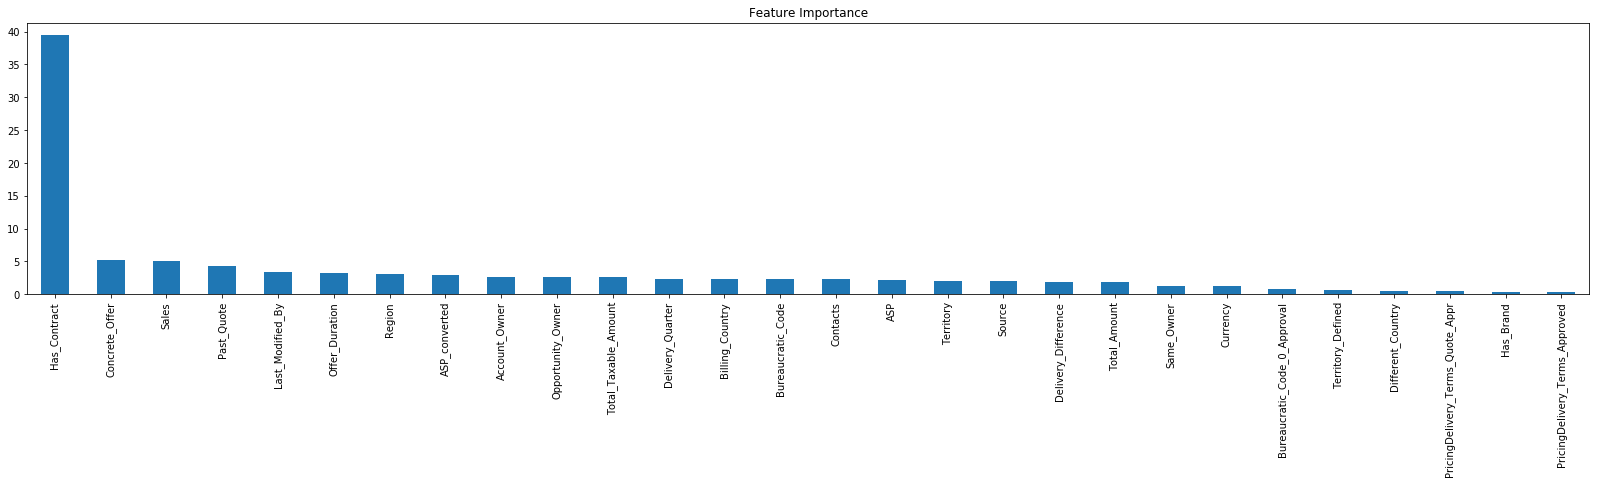

In [820]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [821]:
bad = x_test_pred[(x_test_pred.Prediction > 0.5) & (x_test_pred.Stage == 0) | (x_test_pred.Prediction < 0.5) & (x_test_pred.Stage == 1)]

In [822]:
bad

,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Currency,Last_Modified_By,ASP,ASP_converted,Delivery_Quarter,Total_Amount,Total_Taxable_Amount,Stage,Contacts,Delivery_Difference,Same_Owner,Has_Brand,Has_Contract,Different_Country,TRF_Cat,Sales,Concrete_Offer,Offer_Duration,Territory_Defined,Past_Quote,Prediction
7812,APAC,Australia,1,0,1,0,Bureaucratic_Code_5,None,Australia,4832,2252,Person_Name_43,Person_Name_19,None,Person_Name_47,0.5400,0.38211,Q4,109620.00,109620.00,0,1,7.0,False,False,True,False,0.0,317,181.0,130.0,True,131.0,0.876408
4773,APAC,India,1,1,1,1,Bureaucratic_Code_4,Source_13,Sri Lanka,2824,904,Person_Name_49,Person_Name_49,None,Person_Name_47,0.3600,0.36000,Q4,157172.40,157172.40,0,1,19.0,False,False,True,True,0.0,31,72.0,72.0,True,-27.0,0.998233
9545,EMEA,Germany,0,0,0,0,Bureaucratic_Code_4,Source_9,Germany,6045,None,Person_Name_13,Person_Name_13,None,Person_Name_47,0.4200,0.47506,Q3,30450.00,82700.00,1,2,4.0,False,False,False,False,0.0,125,32.0,4.0,True,160.0,0.473259
9800,APAC,Thailand,0,0,0,0,Bureaucratic_Code_4,Source_7,Thailand,6207,3436,Person_Name_54,Person_Name_54,None,Person_Name_47,0.4000,0.40000,Q4,120060.00,120060.00,0,1,0.0,False,False,True,False,0.0,1,86.0,57.0,True,70.0,0.971816
952,EMEA,Germany,1,0,0,0,Bureaucratic_Code_5,Source_7,Germany,511,1344,Person_Name_4,Person_Name_4,None,Person_Name_41,0.3875,0.43830,Q2,287525.00,287525.00,0,1,12.0,False,False,True,False,1.0,17,88.0,8.0,True,603.0,0.996310
16800,EMEA,None,0,0,0,0,Bureaucratic_Code_4,None,Luxembourg,12726,None,Person_Name_18,Person_Name_20,None,Person_Name_20,0.5400,0.61079,Q1,105300.00,105300.00,1,1,3.0,True,False,False,False,0.0,2,86.0,72.0,False,-8.0,0.101253
9280,Americas,NW America,0,0,0,0,Bureaucratic_Code_4,None,United States,5834,2880,Person_Name_64,Person_Name_64,None,Person_Name_47,0.4300,0.43000,Q4,30702.00,30702.00,0,1,0.0,False,False,True,True,0.0,22,132.0,4.0,True,183.0,0.816659
10407,Americas,None,1,0,0,0,Bureaucratic_Code_5,Source_7,United States,6515,3390,Person_Name_33,Person_Name_33,None,Person_Name_47,0.4950,0.49500,Q1,285862.50,285862.50,0,1,30.0,False,False,True,False,1.0,73,89.0,NaN,False,NaN,0.989840
7806,APAC,Australia,1,1,1,1,Bureaucratic_Code_4,None,Australia,4826,2247,Person_Name_43,Person_Name_19,None,Person_Name_47,0.5400,0.38211,Q4,109620.00,109620.00,0,1,7.0,False,False,True,False,0.0,317,181.0,130.0,True,131.0,0.547387
2607,EMEA,France,1,0,0,0,Bureaucratic_Code_5,None,France,1451,337,Person_Name_16,Person_Name_16,None,Person_Name_47,0.5050,0.57120,Q3,254267.50,507020.00,0,2,7.0,False,False,True,False,1.0,6,186.0,67.0,True,181.0,0.672705


In [847]:
bad.Stage.value_counts()

0    79
1    20
Name: Stage, dtype: int64